In [30]:
cd /content/drive/MyDrive/mongodb_MapReduce/

/content/drive/MyDrive/mongodb_MapReduce


In [69]:
import torch as torch
import dlc_practical_prologue as prologue
import progressbar
from dlc_practical_prologue import *

In [70]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [71]:
train_input, train_target, test_input, test_target = load_data(cifar = True, one_hot_labels =True, normalize =True, flatten = True)

* Using CIFAR
Files already downloaded and verified
Files already downloaded and verified
** Reduce the data-set (use --full for the full thing)
** Use 1000 train and 1000 test samples


In [195]:
 train_input.shape

torch.Size([1000, 3072])

In [196]:
def loss(v,t):
  return torch.sum((t - v).pow(2))

In [197]:
def dloss(v, t):
  return  - 2 * (t - v)

In [198]:
def compute_error(pred,target):
    pred_ones = torch.argmax(pred, dim=1)
    target_ones = torch.nonzero(target)[:, 1]
    return ((pred_ones != target_ones).sum().item() / target.shape[0])

## Activation function

## 1. Sigmoide function

In [199]:
def sigmoid(x):
  s=1/(1+torch.exp(-x))
  return s

In [200]:
def dsigmoid(x):
  s=1/(1+torch.exp(-x))
  ds=s*(1-s)  
  return ds

In [147]:
class Neural_Network1:
  def __init__(self, hidden_size, in_size=3072, out_size=10, lr=0.01, std=1e-6):
    self.W1 = torch.randn((in_size, hidden_size))
    self.b1 = torch.randn((1,hidden_size))
    self.W2 = torch.randn((hidden_size,out_size))
    self.b2 = torch.randn((1,out_size))

    self.dW1 = torch.zeros((in_size, hidden_size))
    self.db1 = torch.zeros((1,hidden_size))
    self.dW2 = torch.zeros((hidden_size,out_size))
    self.db2 = torch.zeros((1,out_size))

    self.lr = lr

  def forward(self,x):
    x_1 = x @ self.W1 + self.b1
    s_1 = sigmoid(x_1)
    x_2 = s_1 @ self.W2 + self.b2
    out =  sigmoid(x_2)
    return x_1, s_1, x_2, out

  def backward_pass(self, t, x, s1, x1,s2, x2):
    self.dW2 = s1.T @ (dloss(s2,t) * dsigmoid(x2)) 
    self.db2 = dloss(s2,t) * dsigmoid(x2)
    self.dW1 = x.T @ ((dloss(s2,t)*dsigmoid(x2)@ self.W2.T) * dsigmoid(x1))
    self.db1 = (dloss(s2,t)*dsigmoid(x2)@ self.W2.T) * dsigmoid(x1)

    self.W1 -= self.lr * self.dW1
    self.b1 -= self.lr * self.db1
    self.W2 -= self.lr * self.dW2
    self.b2 -= self.lr * self.db2


  def zero_gradient(self):
    self.dW1.zero_()
    self.db1.zero_()
    self.dW2.zero_()
    self.db2.zero_()


  def train(self, X, y,test_input,test_target,  epoch):
    test_losses1 = []
    train_losses1 = []
    for i in range(epoch):
      epoch_loss = 0.0
      for j, data in enumerate(X):
        ## forward
        data = data[None,...]
        target = y[j][None,...]
        x_1, s_1, x_2, out = self.forward(data)

        t = target * 0.9 ##  multiply target by 0.9
        epoch_loss += loss(out, t).item() ## loss

        ## backward
        self.backward_pass(t, data, s_1, x_1, out, x_2)

        ## zero gradient
        self.zero_gradient()

      if i % 100 == 0:
        train_loss = loss(model1.forward(test_input)[-1], test_target*0.9)
        train_losses1.append(train_loss)
        test_losses1.append(train_loss / test_input.shape[0])
        print(f'Epoch {i} Train Loss: {epoch_loss/ X.shape[0]} and Test loss: {train_loss / test_input.shape[0]}')
    return (train_losses1, test_losses1)

  def accuracy(self,pred,target):
    pred_ones = torch.argmax(pred, dim=1)
    target_ones = torch.nonzero(target)[:, 1]
    return ((pred_ones == target_ones).sum().item() / target.shape[0])

In [201]:
model1 = Neural_Network1(50,in_size=3072,out_size=10,lr=0.001)
train_losses1, test_losses1 = model1.train(train_input, train_target, test_input, test_target, epoch=500)

Epoch 0 Train Loss: 1.2472176607847214 and Test loss: 0.8563259840011597
Epoch 100 Train Loss: 0.6922504360079765 and Test loss: 0.6964943408966064
Epoch 200 Train Loss: 0.6023364191651345 and Test loss: 0.660029947757721
Epoch 300 Train Loss: 0.4724480913393199 and Test loss: 0.6613358855247498
Epoch 400 Train Loss: 0.333071254666429 and Test loss: 0.6917814016342163


In [204]:
pred1 = model1.forward(train_input)[-1]
model1.accuracy(pred1, train_target)

0.865

In [205]:
pred1 = model1.forward(test_input)[-1]
model1.accuracy(pred1, test_target)

0.294

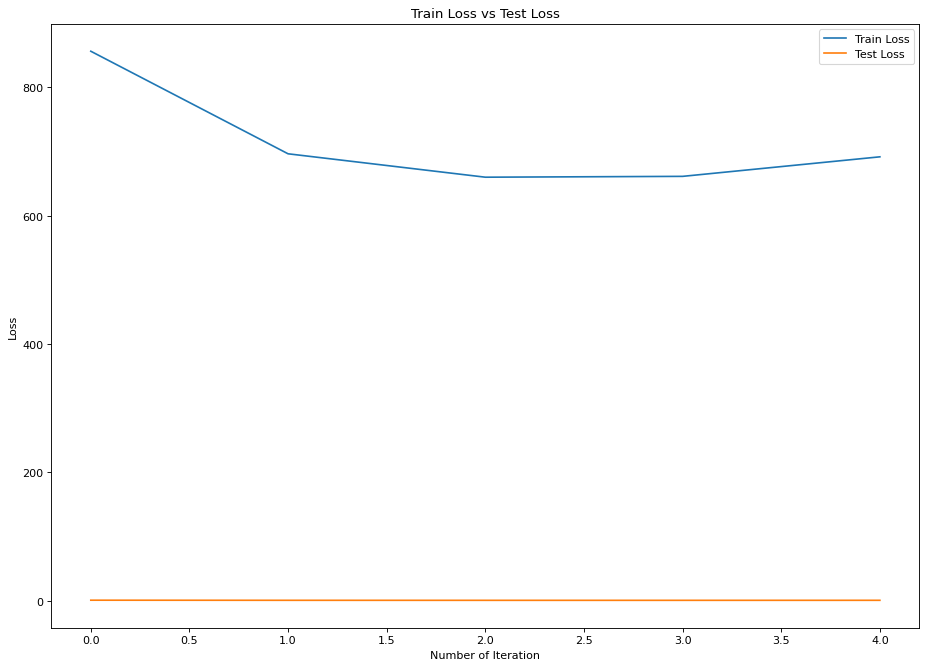

In [206]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,10), dpi = 80)
plt.plot(train_losses1)
plt.plot(test_losses1)
plt.legend(["Train Loss","Test Loss"])
plt.xlabel("Number of Iteration")
plt.ylabel("Loss")
plt.title("Train Loss vs Test Loss")
plt.show()

## 2. scaled sigmoid

In [272]:
def s_sigmoid(x):
  s=(1/(1+torch.exp(-x)))-0.1
  return s

In [273]:
def ds_sigmoid(x):
  s= (1/(1+torch.exp(-x)))-0.1
  ds= (s*(1-s))  
  return ds

In [279]:
class Neural_Network2:
  def __init__(self, hidden_size, in_size=3072, out_size=10, lr=0.01, std=1e-6):
    self.W1 = torch.randn((in_size, hidden_size)).normal_(0, std)
    self.b1 = torch.randn((1,hidden_size)).normal_(0, std)
    self.W2 = torch.randn((hidden_size,out_size)).normal_(0, std)
    self.b2 = torch.randn((1,out_size)).normal_(0, std)

    self.dW1 = torch.zeros((in_size, hidden_size))
    self.db1 = torch.zeros((1,hidden_size))
    self.dW2 = torch.zeros((hidden_size,out_size))
    self.db2 = torch.zeros((1,out_size))

    self.lr = lr

  def forward(self,x):
    x_1 = x @ self.W1 + self.b1
    s_1 = s_sigmoid(x_1)
    x_2 = s_1 @ self.W2 + self.b2
    out =  s_sigmoid(x_2)
    return x_1, s_1, x_2, out

  def backward_pass(self, t, x, s1, x1,s2, x2):
    self.dW2 = s1.T @ (dloss(s2,t) * ds_sigmoid(x2)) 
    self.db2 = dloss(s2,t) * ds_sigmoid(x2)
    self.dW1 = x.T @ ((dloss(s2,t)*ds_sigmoid(x2)@ self.W2.T) * ds_sigmoid(x1))
    self.db1 = (dloss(s2,t)*ds_sigmoid(x2)@ self.W2.T) * ds_sigmoid(x1)

    self.W1 -= self.lr * self.dW1
    self.b1 -= self.lr * self.db1
    self.W2 -= self.lr * self.dW2
    self.b2 -= self.lr * self.db2


  def zero_gradient(self):
    self.dW1.zero_()
    self.db1.zero_()
    self.dW2.zero_()
    self.db2.zero_()


  def train(self, X, y,test_input,test_target,  epoch):
    test_losses2 = []
    train_losses2 = []
    for i in range(epoch):
      epoch_loss = 0.0
      for j, data in enumerate(X):
        ## forward
        data = data[None,...]
        target = y[j][None,...]
        x_1, s_1, x_2, out = self.forward(data)

        t = target * 0.9 ##  multiply target by 0.9
        epoch_loss += loss(out, t).item() ## loss

        ## backward
        self.backward_pass(t, data, s_1, x_1, out, x_2)

        ## zero gradient
        self.zero_gradient()

      if i % 100 == 0:
        train_loss = loss(model2.forward(test_input)[-1], test_target*0.9)
        train_losses2.append(train_loss)
        test_losses2.append(train_loss / test_input.shape[0])
        print(f'Epoch {i} Train Loss: {epoch_loss/ X.shape[0]} and Test loss: {train_loss / test_input.shape[0]}')
    return (train_losses2, test_losses2)

  def accuracy(self,pred,target):
    pred_ones = torch.argmax(pred, dim=1)
    target_ones = torch.nonzero(target)[:, 1]
    return ((pred_ones == target_ones).sum().item() / target.shape[0])

In [280]:
model2 = Neural_Network2(50,in_size=3072,out_size=10,lr=0.001)
train_losses2, test_losses2 = model2.train(train_input, train_target, test_input, test_target, epoch=500)

Epoch 0 Train Loss: 1.1362428067922592 and Test loss: 0.8676419258117676
Epoch 100 Train Loss: 0.6868248894512653 and Test loss: 0.6926253437995911
Epoch 200 Train Loss: 0.8597319418489933 and Test loss: 0.8735001087188721
Epoch 300 Train Loss: 0.9387050076127053 and Test loss: 0.9410659074783325
Epoch 400 Train Loss: 0.9416140313148499 and Test loss: 0.9463579058647156


In [281]:
pred2 = model2.forward(train_input)[-1]
model2.accuracy(pred2, train_target)

0.147

In [282]:
pred2 = model2.forward(test_input)[-1]
model2.accuracy(pred2, test_target)

0.128

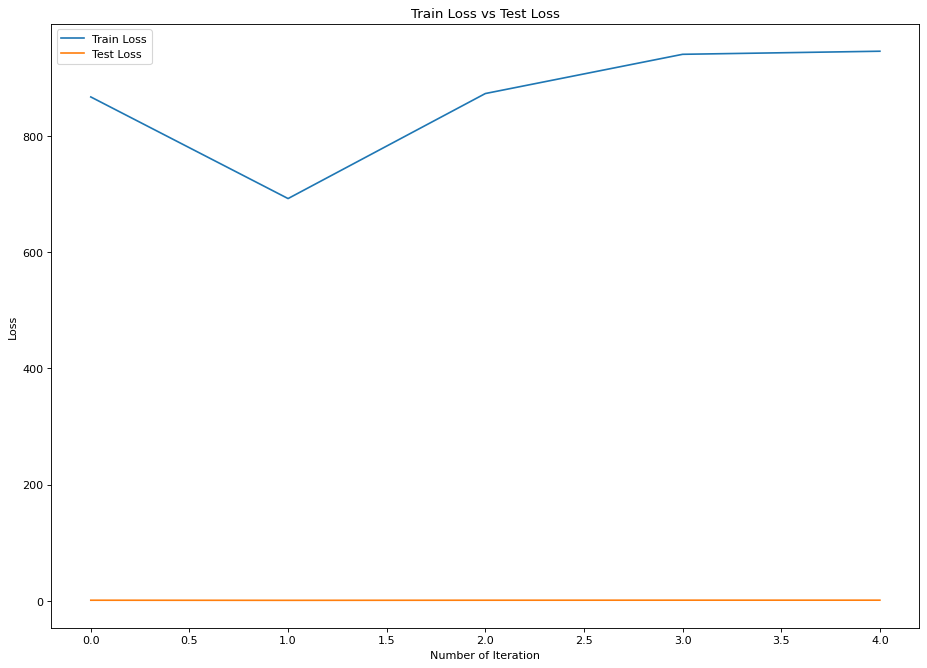

In [283]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,10), dpi = 80)
plt.plot(train_losses2)
plt.plot(test_losses2)
plt.legend(["Train Loss","Test Loss"])
plt.xlabel("Number of Iteration")
plt.ylabel("Loss")
plt.title("Train Loss vs Test Loss")
plt.show()

## 3. Tanh

In [116]:
def sigma(x):
  return torch.tanh(x)

In [117]:
def dsigma(x):
  return 1 - torch.tanh(x)**2

In [118]:
class Neural_Network3:
  def __init__(self, hidden_size, in_size=3072, out_size=10, lr=0.01, std=1e-6):
    self.W1 = torch.randn((in_size, hidden_size)).normal_(0, std)
    self.b1 = torch.randn((1,hidden_size)).normal_(0, std)
    self.W2 = torch.randn((hidden_size,out_size)).normal_(0, std)
    self.b2 = torch.randn((1,out_size)).normal_(0, std)

    self.dW1 = torch.zeros((in_size, hidden_size))
    self.db1 = torch.zeros((1,hidden_size))
    self.dW2 = torch.zeros((hidden_size,out_size))
    self.db2 = torch.zeros((1,out_size))

    self.lr = lr

  def forward(self,x):
    x_1 = x @ self.W1 + self.b1
    s_1 = sigma(x_1)
    x_2 = s_1 @ self.W2 + self.b2
    out =  sigma(x_2)
    return x_1, s_1, x_2, out

  def backward_pass(self, t, x, s1, x1,s2, x2):
    self.dW2 = s1.T @ (dloss(s2,t) * dsigma(x2)) 
    self.db2 = dloss(s2,t) * dsigma(x2)
    self.dW1 = x.T @ ((dloss(s2,t)*dsigma(x2)@ self.W2.T) * dsigma(x1))
    self.db1 = (dloss(s2,t)*dsigma(x2)@ self.W2.T) * dsigma(x1)

    self.W1 -= self.lr * self.dW1
    self.b1 -= self.lr * self.db1
    self.W2 -= self.lr * self.dW2
    self.b2 -= self.lr * self.db2


  def zero_gradient(self):
    self.dW1.zero_()
    self.db1.zero_()
    self.dW2.zero_()
    self.db2.zero_()


  def train(self, X, y,test_input,test_target,  epoch):
    test_losses3 = []
    train_losses3 = []
    for i in range(epoch):
      epoch_loss = 0.0
      for j, data in enumerate(X):
        ## forward
        data = data[None,...]
        target = y[j][None,...]
        x_1, s_1, x_2, out = self.forward(data)

        t = target * 0.9 ##  multiply target by 0.9
        epoch_loss += loss(out, t).item() ## loss

        ## backward
        self.backward_pass(t, data, s_1, x_1, out, x_2)

        ## zero gradient
        self.zero_gradient()

      if i % 100 == 0:
        train_loss = loss(model3.forward(test_input)[-1], test_target*0.9)
        train_losses3.append(train_loss)
        test_losses3.append(train_loss / test_input.shape[0])
        print(f'Epoch {i} Train Loss: {epoch_loss/ X.shape[0]} and Test loss: {train_loss / test_input.shape[0]}')
    return (train_losses3, test_losses3)

  def accuracy(self,pred,target):
    pred_ones = torch.argmax(pred, dim=1)
    target_ones = torch.nonzero(target)[:, 1]
    return ((pred_ones == target_ones).sum().item() / target.shape[0])

In [119]:
model3 = Neural_Network3(50,in_size=3072,out_size=10,lr=0.25)
train_losses3, test_losses3 = model3.train(train_input, train_target, test_input, test_target, epoch=500)

Epoch 0 Train Loss: 0.7747723453342915 and Test loss: 0.8472880125045776
Epoch 100 Train Loss: 0.2608267909102142 and Test loss: 1.446847677230835
Epoch 200 Train Loss: 0.2047731765974313 and Test loss: 1.482849359512329
Epoch 300 Train Loss: 0.1842573622148484 and Test loss: 1.4972350597381592
Epoch 400 Train Loss: 0.17321607326343655 and Test loss: 1.5628221035003662


In [120]:
pred3 = model3.forward(train_input)[-1]
model3.accuracy(pred3, train_target)

0.971

In [121]:
pred3 = model3.forward(test_input)[-1]
model3.accuracy(pred3, test_target)

0.193

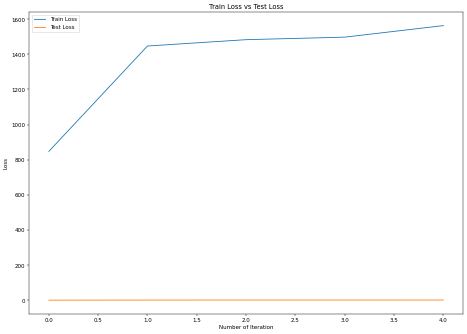

In [122]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,10), dpi = 40)
plt.plot(train_losses3)
plt.plot(test_losses3)
plt.legend(["Train Loss","Test Loss"])
plt.xlabel("Number of Iteration")
plt.ylabel("Loss")
plt.title("Train Loss vs Test Loss")
plt.show()

## 4. penalized tanh

In [123]:
def tanh(x, a):
  return torch.where(x>0, torch.tanh(x), a*torch.tanh(x))

In [124]:
def dtanh(x, a):
  t = torch.tanh(x)
  return torch.where(x>0, 1-t**2, a*(1-t**2))

In [125]:
class Neural_Network4:
  def __init__(self, hidden_size, in_size=3072, out_size=10, lr=0.01, std=1e-6):
    self.W1 = torch.randn((in_size, hidden_size)).normal_(0, std)
    self.b1 = torch.randn((1,hidden_size)).normal_(0, std)
    self.W2 = torch.randn((hidden_size,out_size)).normal_(0, std)
    self.b2 = torch.randn((1,out_size)).normal_(0, std)

    self.dW1 = torch.zeros((in_size, hidden_size))
    self.db1 = torch.zeros((1,hidden_size))
    self.dW2 = torch.zeros((hidden_size,out_size))
    self.db2 = torch.zeros((1,out_size))

    self.lr = lr

  def forward(self,x):
    x_1 = x @ self.W1 + self.b1
    s_1 = tanh(x_1, 0.25)
    x_2 = s_1 @ self.W2 + self.b2
    out =  tanh(x_2, 0.25)
    return x_1, s_1, x_2, out

  def backward_pass(self, t, x, s1, x1,s2, x2):
    self.dW2 = s1.T @ (dloss(s2,t) * dtanh(x2, 0.25)) 
    self.db2 = dloss(s2,t) * dtanh(x2, 0.25)
    self.dW1 = x.T @ ((dloss(s2,t)*dtanh(x2, 0.25)@ self.W2.T) * dtanh(x1, 0.25))
    self.db1 = (dloss(s2,t)*dtanh(x2, 0.25)@ self.W2.T) * dtanh(x1, 0.25)

    self.W1 -= self.lr * self.dW1
    self.b1 -= self.lr * self.db1
    self.W2 -= self.lr * self.dW2
    self.b2 -= self.lr * self.db2


  def zero_gradient(self):
    self.dW1.zero_()
    self.db1.zero_()
    self.dW2.zero_()
    self.db2.zero_()


  def train(self, X, y,test_input,test_target,  epoch):
    test_losses4 = []
    train_losses4 = []
    for i in range(epoch):
      epoch_loss = 0.0
      for j, data in enumerate(X):
        ## forward
        data = data[None,...]
        target = y[j][None,...]
        x_1, s_1, x_2, out = self.forward(data)

        t = target * 0.9 ##  multiply target by 0.9
        epoch_loss += loss(out, t).item() ## loss

        ## backward
        self.backward_pass(t, data, s_1, x_1, out, x_2)

        ## zero gradient
        self.zero_gradient()

      if i % 100 == 0:
        train_loss = loss(model4.forward(test_input)[-1], test_target*0.9)
        train_losses4.append(train_loss)
        test_losses4.append(train_loss / test_input.shape[0])
        print(f'Epoch {i} Train Loss: {epoch_loss/ X.shape[0]} and Test loss: {train_loss / test_input.shape[0]}')
    return (train_losses4, test_losses4)

  def accuracy(self,pred,target):
    pred_ones = torch.argmax(pred, dim=1)
    target_ones = torch.nonzero(target)[:, 1]
    return ((pred_ones == target_ones).sum().item() / target.shape[0])

In [126]:
model4 = Neural_Network4(50,in_size=3072,out_size=10,lr=0.25)
train_losses4, test_losses4 = model4.train(train_input, train_target, test_input, test_target, epoch=500)

Epoch 0 Train Loss: 0.7252363239005208 and Test loss: 0.705921471118927
Epoch 100 Train Loss: 0.08047511616535485 and Test loss: 1.0342426300048828
Epoch 200 Train Loss: 0.0585998527482152 and Test loss: 1.0978611707687378
Epoch 300 Train Loss: 0.05228255919646472 and Test loss: 1.1228859424591064
Epoch 400 Train Loss: 0.04690475866105408 and Test loss: 1.1525079011917114


In [127]:
pred4 = model4.forward(train_input)[-1]
model4.accuracy(pred4, train_target)

1.0

In [128]:
pred4 = model4.forward(test_input)[-1]
model4.accuracy(pred4, test_target)

0.227

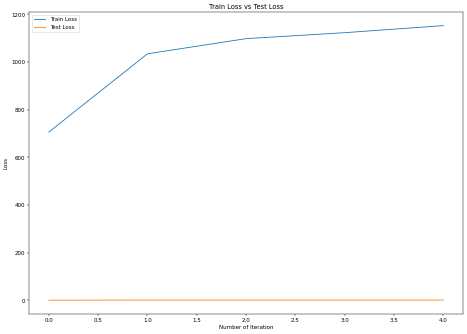

In [129]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,10), dpi = 40)
plt.plot(train_losses4)
plt.plot(test_losses4)
plt.legend(["Train Loss","Test Loss"])
plt.xlabel("Number of Iteration")
plt.ylabel("Loss")
plt.title("Train Loss vs Test Loss")
plt.show()

## 5. ReLU

In [130]:
def ReLU(x):
  return x * torch.where(x>0) 

In [131]:
def dReLU(x):
  return 1 * torch.where(x>0) 

In [132]:
class Neural_Network5:
  def __init__(self, hidden_size, in_size=3072, out_size=10, lr=0.01, std=1e-6):
    self.W1 = torch.randn((in_size, hidden_size)).normal_(0, std)
    self.b1 = torch.randn((1,hidden_size)).normal_(0, std)
    self.W2 = torch.randn((hidden_size,out_size)).normal_(0, std)
    self.b2 = torch.randn((1,out_size)).normal_(0, std)

    self.dW1 = torch.zeros((in_size, hidden_size))
    self.db1 = torch.zeros((1,hidden_size))
    self.dW2 = torch.zeros((hidden_size,out_size))
    self.db2 = torch.zeros((1,out_size))

    self.lr = lr

  def forward(self,x):
    x_1 = x @ self.W1 + self.b1
    s_1 = tanh(x_1, 0.25)
    x_2 = s_1 @ self.W2 + self.b2
    out =  tanh(x_2, 0.25)
    return x_1, s_1, x_2, out

  def backward_pass(self, t, x, s1, x1,s2, x2):
    self.dW2 = s1.T @ (dloss(s2,t) * dtanh(x2, 0.25)) 
    self.db2 = dloss(s2,t) * tanh(x2, 0.25)
    self.dW1 = x.T @ ((dloss(s2,t)*tanh(x2, 0.25)@ self.W2.T) * tanh(x1, 0.25))
    self.db1 = (dloss(s2,t)*tanh(x2, 0.25)@ self.W2.T) * tanh(x1, 0.25)

    self.W1 -= self.lr * self.dW1
    self.b1 -= self.lr * self.db1
    self.W2 -= self.lr * self.dW2
    self.b2 -= self.lr * self.db2


  def zero_gradient(self):
    self.dW1.zero_()
    self.db1.zero_()
    self.dW2.zero_()
    self.db2.zero_()


  def train(self, X, y,test_input,test_target,  epoch):
    test_losses5 = []
    train_losses5 = []
    for i in range(epoch):
      epoch_loss = 0.0
      for j, data in enumerate(X):
        ## forward
        data = data[None,...]
        target = y[j][None,...]
        x_1, s_1, x_2, out = self.forward(data)

        t = target * 0.9 ##  multiply target by 0.9
        epoch_loss += loss(out, t).item() ## loss

        ## backward
        self.backward_pass(t, data, s_1, x_1, out, x_2)

        ## zero gradient
        self.zero_gradient()

      if i % 100 == 0:
        train_loss = loss(model5.forward(test_input)[-1], test_target*0.9)
        train_losses5.append(train_loss)
        test_losses5.append(train_loss / test_input.shape[0])
        print(f'Epoch {i} Train Loss: {epoch_loss/ X.shape[0]} and Test loss: {train_loss / test_input.shape[0]}')
    return (train_losses5, test_losses5)

  def accuracy(self,pred,target):
    pred_ones = torch.argmax(pred, dim=1)
    target_ones = torch.nonzero(target)[:, 1]
    return ((pred_ones == target_ones).sum().item() / target.shape[0])

In [133]:
model5 = Neural_Network5(50,in_size=3072,out_size=10,lr=0.25)
train_losses5, test_losses5 = model5.train(train_input, train_target, test_input, test_target, epoch=500)

Epoch 0 Train Loss: 0.80999906873703 and Test loss: 0.8099977970123291
Epoch 100 Train Loss: 1.189511601984501 and Test loss: 1.1921335458755493
Epoch 200 Train Loss: 1.8849999904632568 and Test loss: 1.8849998712539673
Epoch 300 Train Loss: 1.8849999904632568 and Test loss: 1.8849998712539673
Epoch 400 Train Loss: 1.8849999904632568 and Test loss: 1.8849998712539673


In [134]:
pred5 = model5.forward(train_input)[-1]
model5.accuracy(pred5, train_target)

0.102

In [135]:
pred5 = model5.forward(test_input)[-1]
model5.accuracy(pred5, test_target)

0.103

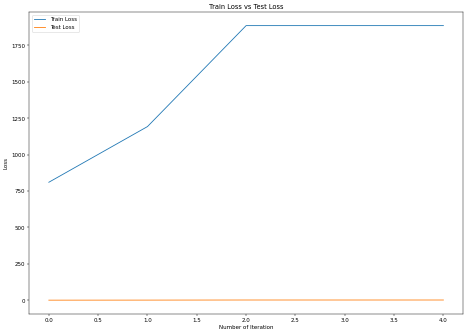

In [136]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,10), dpi = 40)
plt.plot(train_losses5)
plt.plot(test_losses5)
plt.legend(["Train Loss","Test Loss"])
plt.xlabel("Number of Iteration")
plt.ylabel("Loss")
plt.title("Train Loss vs Test Loss")
plt.show()

## 6. Leaky ReLU

In [137]:
def LeakyReLU(x, a):
  return torch.where(x>0, x, x*a) 

In [138]:
def dLeakyReLU(x, a):
  return torch.where(x>0, 1, a) 

In [139]:
class Neural_Network6:
  def __init__(self, hidden_size, in_size=3072, out_size=10, lr=0.01, std=1e-6):
    self.W1 = torch.randn((in_size, hidden_size)).normal_(0, std)
    self.b1 = torch.randn((1,hidden_size)).normal_(0, std)
    self.W2 = torch.randn((hidden_size,out_size)).normal_(0, std)
    self.b2 = torch.randn((1,out_size)).normal_(0, std)

    self.dW1 = torch.zeros((in_size, hidden_size))
    self.db1 = torch.zeros((1,hidden_size))
    self.dW2 = torch.zeros((hidden_size,out_size))
    self.db2 = torch.zeros((1,out_size))

    self.lr = lr

  def forward(self,x):
    x_1 = x @ self.W1 + self.b1
    s_1 = tanh(x_1, 0.25)
    x_2 = s_1 @ self.W2 + self.b2
    out =  tanh(x_2, 0.25)
    return x_1, s_1, x_2, out

  def backward_pass(self, t, x, s1, x1,s2, x2):
    self.dW2 = s1.T @ (dloss(s2,t) * dtanh(x2, 0.25)) 
    self.db2 = dloss(s2,t) * tanh(x2, 0.25)
    self.dW1 = x.T @ ((dloss(s2,t)*tanh(x2, 0.25)@ self.W2.T) * tanh(x1, 0.25))
    self.db1 = (dloss(s2,t)*tanh(x2, 0.25)@ self.W2.T) * tanh(x1, 0.25)

    self.W1 -= self.lr * self.dW1
    self.b1 -= self.lr * self.db1
    self.W2 -= self.lr * self.dW2
    self.b2 -= self.lr * self.db2


  def zero_gradient(self):
    self.dW1.zero_()
    self.db1.zero_()
    self.dW2.zero_()
    self.db2.zero_()


  def train(self, X, y,test_input,test_target,  epoch):
    test_losses5 = []
    train_losses5 = []
    for i in range(epoch):
      epoch_loss = 0.0
      for j, data in enumerate(X):
        ## forward
        data = data[None,...]
        target = y[j][None,...]
        x_1, s_1, x_2, out = self.forward(data)

        t = target * 0.9 ##  multiply target by 0.9
        epoch_loss += loss(out, t).item() ## loss

        ## backward
        self.backward_pass(t, data, s_1, x_1, out, x_2)

        ## zero gradient
        self.zero_gradient()

      if i % 100 == 0:
        train_loss = loss(model6.forward(test_input)[-1], test_target*0.9)
        train_losses6.append(train_loss)
        test_losses6.append(train_loss / test_input.shape[0])
        print(f'Epoch {i} Train Loss: {epoch_loss/ X.shape[0]} and Test loss: {train_loss / test_input.shape[0]}')
    return (train_losses6, test_losses6)

  def accuracy(self,pred,target):
    pred_ones = torch.argmax(pred, dim=1)
    target_ones = torch.nonzero(target)[:, 1]
    return ((pred_ones == target_ones).sum().item() / target.shape[0])

In [140]:
model6 = Neural_Network5(50,in_size=3072,out_size=10,lr=0.25 )
train_losses6, test_losses6 = model6.train(train_input, train_target, test_input, test_target, epoch=500)

Epoch 0 Train Loss: 0.8099978874921798 and Test loss: 1.8849998712539673
Epoch 100 Train Loss: 1.8849999904632568 and Test loss: 1.8849998712539673
Epoch 200 Train Loss: 1.8849999904632568 and Test loss: 1.8849998712539673
Epoch 300 Train Loss: 1.8849999904632568 and Test loss: 1.8849998712539673
Epoch 400 Train Loss: 1.8849999904632568 and Test loss: 1.8849998712539673


In [142]:
pred6 = model6.forward(train_input)[-1]
model6.accuracy(pred6, train_target)

0.102

In [143]:
pred6 = model6.forward(test_input)[-1]
model6.accuracy(pred6, test_target)

0.103

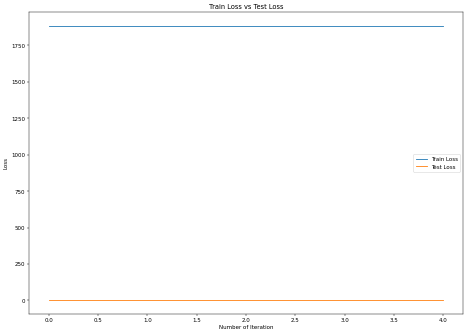

In [144]:
plt.figure(figsize=(14,10), dpi = 40)
plt.plot(train_losses6)
plt.plot(test_losses6)
plt.legend(["Train Loss","Test Loss"])
plt.xlabel("Number of Iteration")

plt.ylabel("Loss")
plt.title("Train Loss vs Test Loss")
plt.show()

In [260]:
import numpy as np
import pandas as pd

In [261]:
x = torch.linspace(-10, 10, 100)

In [262]:
df = pd.DataFrame(dict(
    x=x,
    s_sigmoid = s_sigmoid(x),
    sigmoid = sigmoid(x)
    # Tanh = sigma(x),
    # relu = ReLU(x)
))

In [263]:
import matplotlib.pyplot as plt

AttributeError: ignored

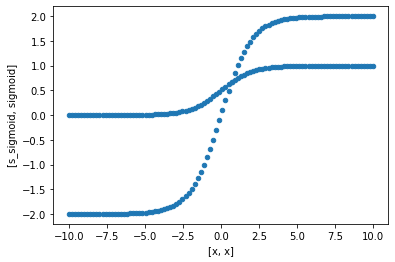

In [264]:
fig = df.plot.scatter(x=["x", "x"], y=["s_sigmoid","sigmoid"])
fig.show()